In [1]:
import pandas as pd
import numpy as np
import  matplotlib.pyplot as plt
import tensorboard 
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torchvision import models
from torchvision import transforms
from torchvision import datasets
import os
# import VGG16 model and VGG 19 model
from torchvision.models import vgg16, vgg19

# VGG 3 with data augmentation 

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import time
from torch.utils.tensorboard import SummaryWriter

# Define the VGG3 model
class VGG3(nn.Module):
    def __init__(self):
        super(VGG3, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 25 * 25, 128),  # Assuming input is (200, 200, 3)
            nn.ReLU(inplace=True),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Instantiate the model and define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VGG3().to(device)

# Count the model parameters
num_params = sum(p.numel() for p in model.parameters())
print(f"Number of model parameters: {num_params}")

# Define loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

writer = SummaryWriter('runs/vgg3_experiment_data_aug')

# Training and testing data transformations
transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor()
])

# Load dataset (replace with your dataset path)
# Updated transform with data augmentation
train_transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),
    transforms.ToTensor()
])

# Apply different transformations for the test dataset to keep it consistent
test_transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor()
])

# Load the dataset with augmented train images
train_dataset = datasets.ImageFolder(r"D:\Users\abhay\Downloads\ML_Classes\ES-335-Assignment-4\Q-1\Dataset\train", transform=transform)
test_dataset = datasets.ImageFolder(r"D:\Users\abhay\Downloads\ML_Classes\ES-335-Assignment-4\Q-1\Dataset\test", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
# Training loop
def train(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    global_step = 0  # Keep track of the iteration number across epochs

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.float().view(-1, 1).to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Update running loss and accuracy
            running_loss += loss.item() * images.size(0)
            preds = (outputs > 0.5).float()
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

            # Log scalars to TensorBoard
            writer.add_scalar('Training Loss', loss.item(), global_step)
            writer.add_scalar('Training Accuracy', correct_train / total_train, global_step)
            global_step += 1

        # Calculate and log testing accuracy
        model.eval()
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.float().view(-1, 1).to(device)
                outputs = model(images)
                preds = (outputs > 0.5).float()
                correct_test += (preds == labels).sum().item()
                total_test += labels.size(0)
                
                # Log the images with predictions to TensorBoard once per epoch
                writer.add_images('Test Images', images, epoch)
                writer.add_text('Predictions', str(preds), epoch)

        test_accuracy = correct_test / total_test
        writer.add_scalar('Testing Accuracy', test_accuracy, global_step)

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {running_loss / len(train_loader.dataset):.4f}, "
              f"Train Accuracy: {correct_train / total_train:.4f}, "
              f"Test Accuracy: {test_accuracy:.4f}")

    writer.close()

# Run training
start_time = time.time()
train(model, train_loader, test_loader, criterion, optimizer, num_epochs=10)
end_time = time.time()
print(f"Training time: {end_time - start_time:.2f}s")


Number of model parameters: 10333505
Epoch [1/10], Train Loss: 0.6930, Train Accuracy: 0.5125, Test Accuracy: 0.5250
Epoch [2/10], Train Loss: 0.6927, Train Accuracy: 0.5938, Test Accuracy: 0.6750
Epoch [3/10], Train Loss: 0.6921, Train Accuracy: 0.6375, Test Accuracy: 0.7500
Epoch [4/10], Train Loss: 0.6915, Train Accuracy: 0.5312, Test Accuracy: 0.5250
Epoch [5/10], Train Loss: 0.6907, Train Accuracy: 0.5000, Test Accuracy: 0.5250
Epoch [6/10], Train Loss: 0.6901, Train Accuracy: 0.5125, Test Accuracy: 0.5500
Epoch [7/10], Train Loss: 0.6894, Train Accuracy: 0.5375, Test Accuracy: 0.5750
Epoch [8/10], Train Loss: 0.6887, Train Accuracy: 0.5938, Test Accuracy: 0.6250
Epoch [9/10], Train Loss: 0.6882, Train Accuracy: 0.5938, Test Accuracy: 0.6250
Epoch [10/10], Train Loss: 0.6872, Train Accuracy: 0.6125, Test Accuracy: 0.6000
Training time: 648.14s


In [6]:
# mke prediction on each image in the test set
model.eval()
correct = 0
for data, target in test_loader:
    # get the inputs; data is a routine tensor
    data, target = data.to(device), target.to(device)
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward + backward + optimize
    output = model(data)
    # get the index of the max log-probability
    pred = output.max(1, keepdim=True)[1]
    correct += pred.eq(target.view_as(pred)).sum().item()
    
print(f"Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)")

Accuracy: 20/40 (50%)


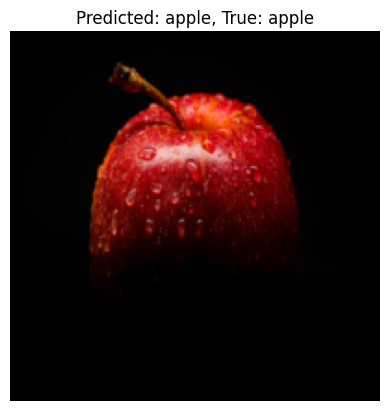

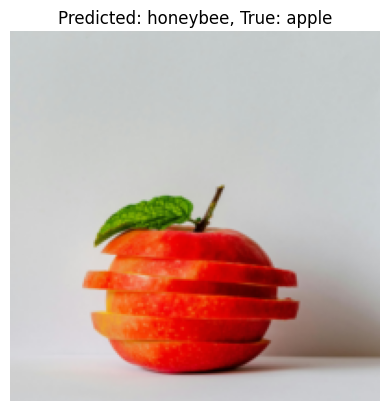

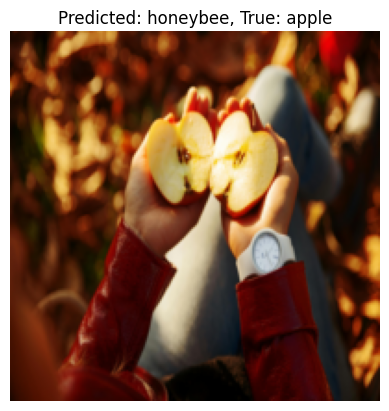

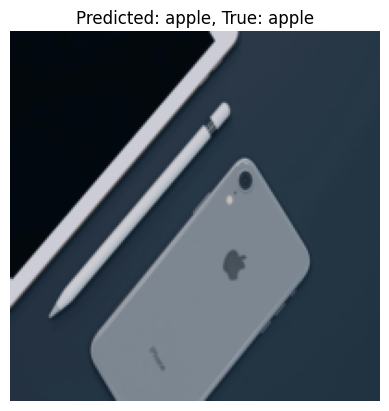

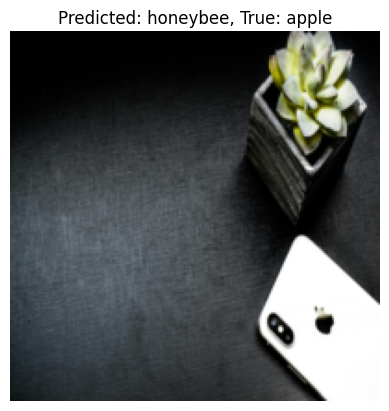

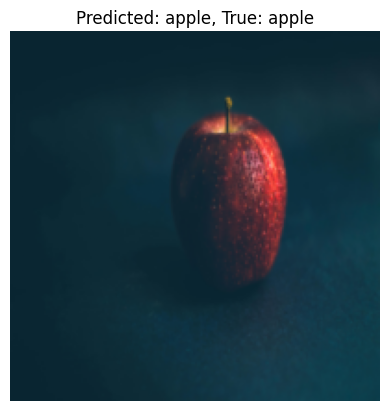

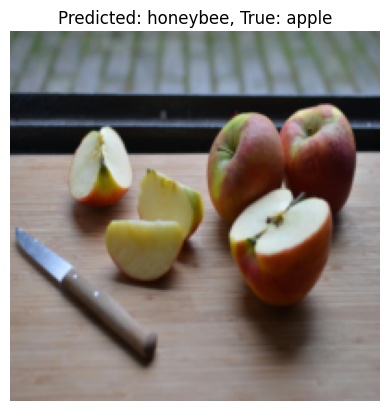

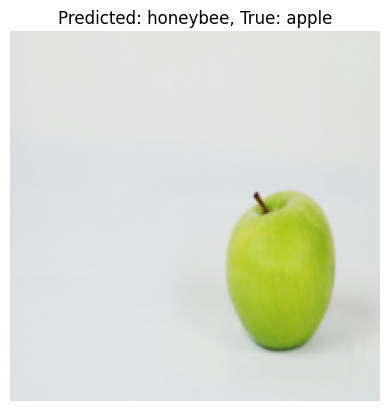

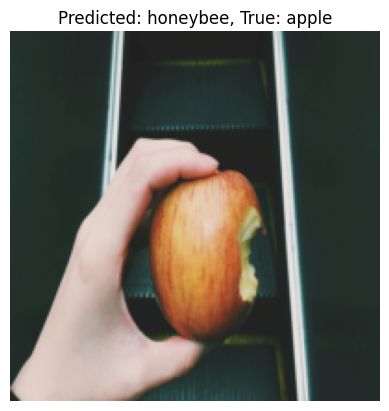

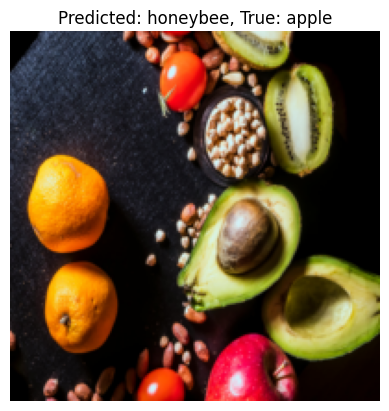

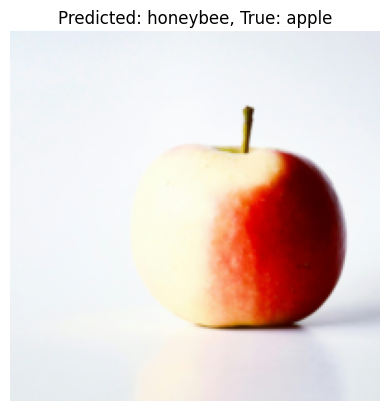

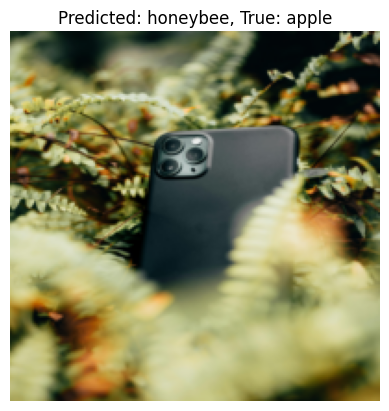

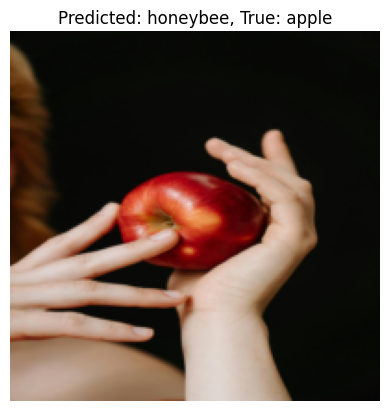

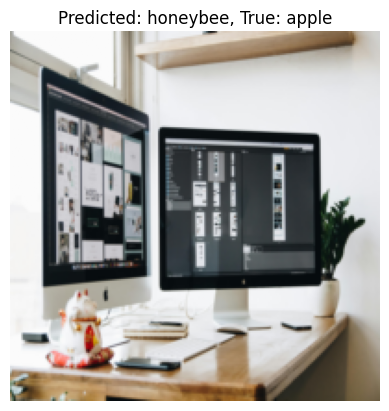

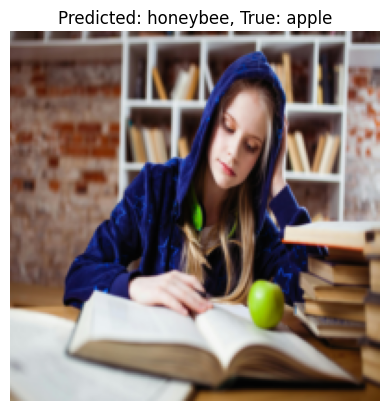

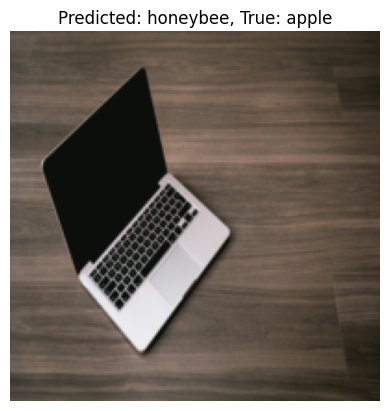

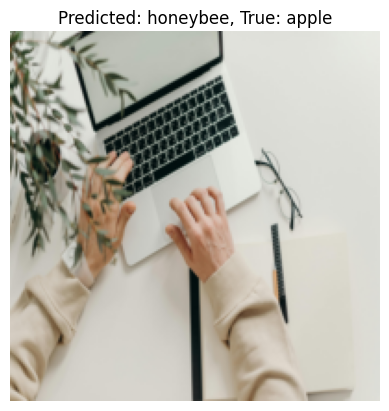

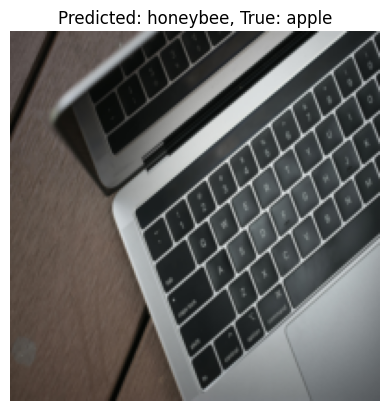

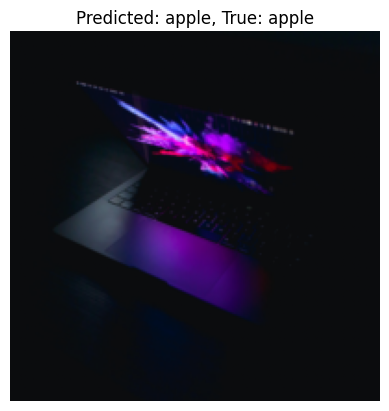

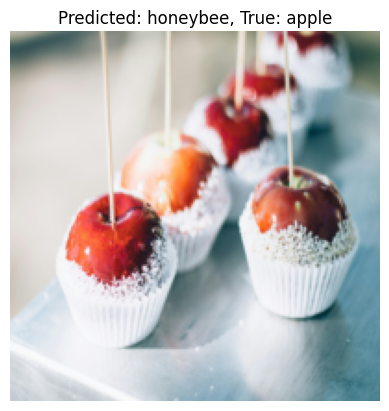

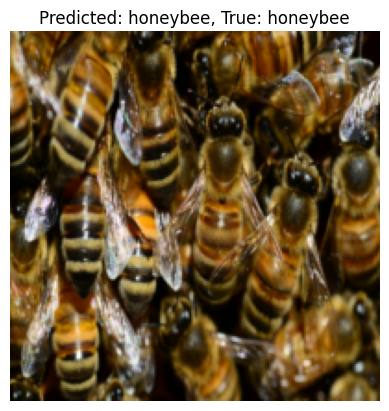

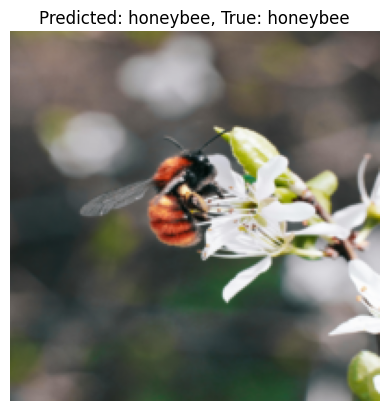

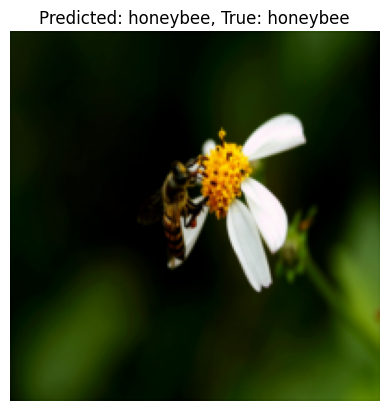

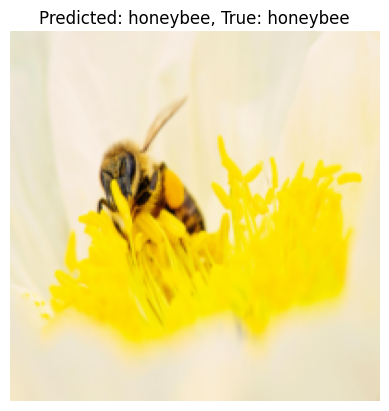

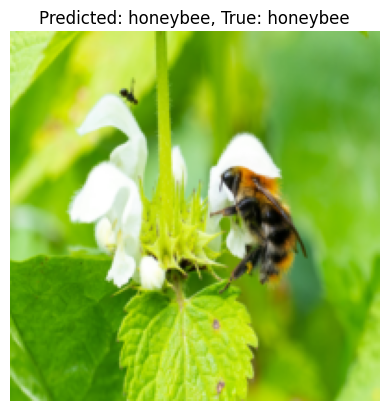

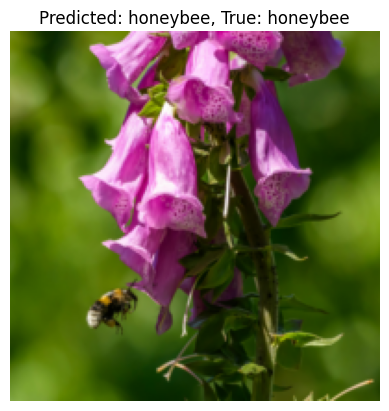

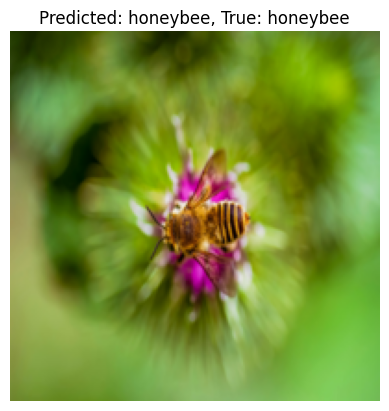

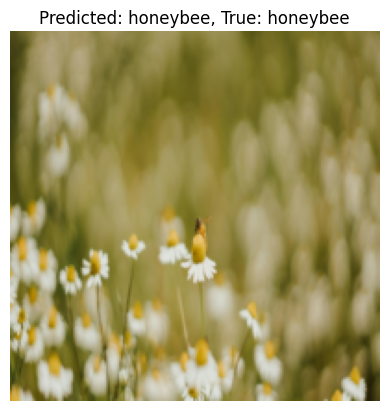

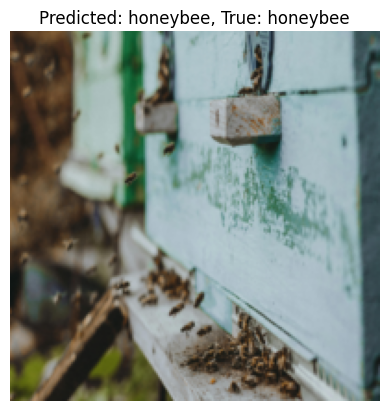

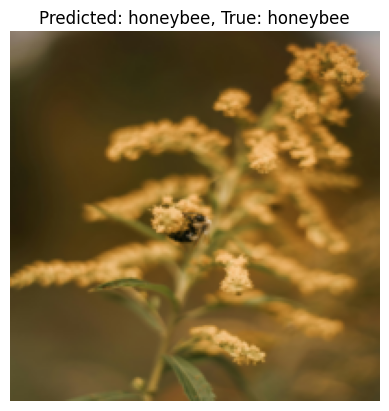

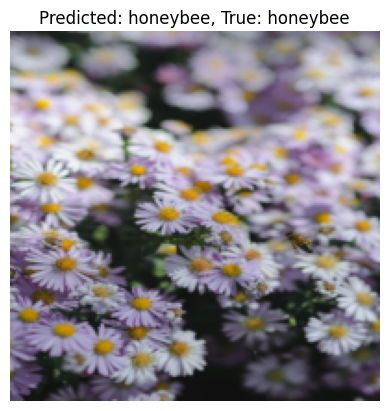

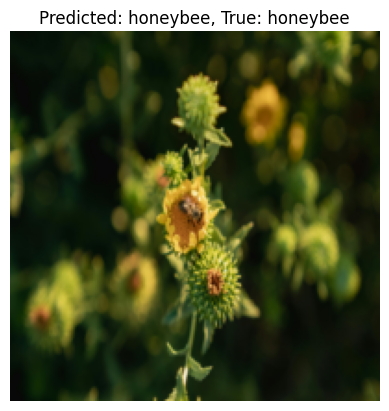

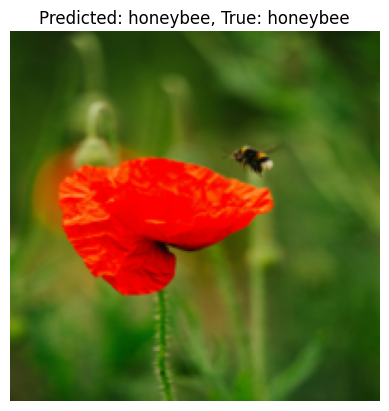

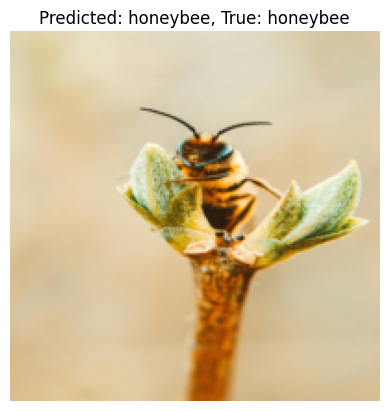

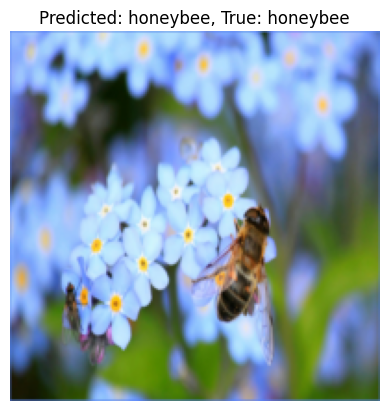

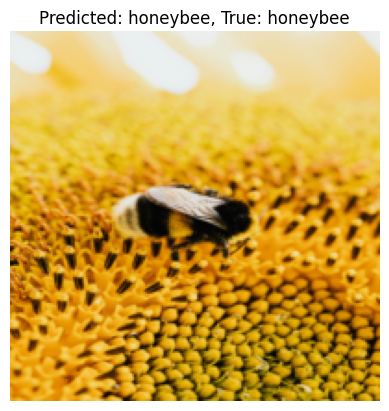

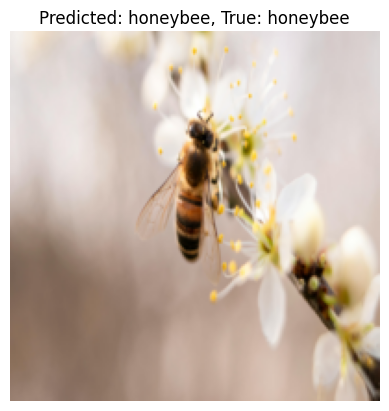

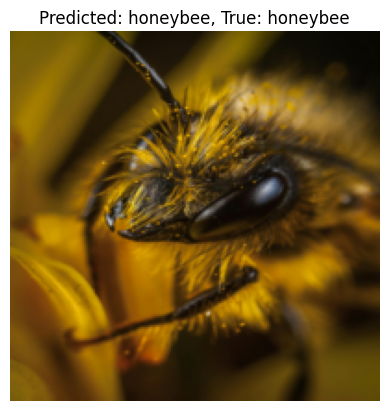

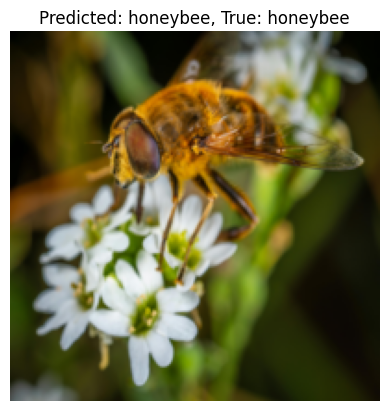

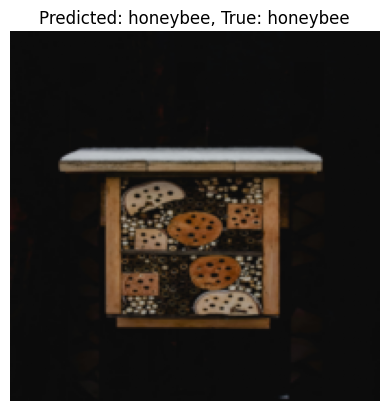

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function to display an image and its labels
def show_image(img, pred_label, true_label):
    img = img.cpu().numpy().transpose((1, 2, 0))  # Convert from Tensor to numpy array and reshape for display
    img = np.clip(img, 0, 1)  # Clip pixel values to be in range [0, 1]
    
    plt.imshow(img)
    plt.title(f"Predicted: {pred_label}, True: {true_label}")
    plt.axis("off")
    plt.show()

# Prediction loop for test images
model.eval()  # Set model to evaluation mode
class_names = test_dataset.classes  # Retrieve class names from the dataset

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Get model predictions
        outputs = model(images)
        preds = (outputs > 0.5).float().squeeze()  # Convert to binary labels (0 or 1 for binary classification)

        # Display each image with its prediction and true label
        for i in range(images.size(0)):
            img = images[i]
            true_label = class_names[int(labels[i].item())]
            pred_label = class_names[int(preds[i].item())]
            show_image(img, pred_label, true_label)


In [5]:
model_path = 'vgg3_data_model.pth'
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")


Model saved to vgg3_data_model.pth
